<a href="https://www.kaggle.com/code/markusayt/src-models-notebookea554506b2?scriptVersionId=162606177" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Check for colab or kaggle
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [3]:
#check for internet on in kaggle if the client is run on kaggle
import socket,warnings
if kaggle:

    try:
        socket.setdefaulttimeout(1)
        socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
    except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
#If using FastAI, this will need to be ran to give latest version
"""if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai"""

'if colab:\n    !pip install -Uqq fastbook\n    import fastbook\n    fastbook.setup_book()\n\nelif kaggle:\n    !pip install -Uqq fastai'

In [5]:
# Opening from different sources to allow for use of local IDE as well as run in kaggle
# Kaggle and local version is linked through github

from pathlib import Path
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('/kaggle/input/turbine-data/Onsite-MetMast-SCADA-data-2017.xlsx')
    DATAScada = Path("/kaggle/input/turbine-data/Wind-Turbine-SCADA-signals-2017_0.xlsx")
    DATAFailures = Path("/kaggle/input/turbine-data/opendata-wind-failures-2017.xlsx")

else:
    DATA = "../../data/processed/Onsite-MetMast-SCADA-data-2017.xlsx"
    DATAScada = "../../data/processed/Wind-Turbine-SCADA-signals-2017_0.xlsx"
    DATAFailures = "../../data/processed/opendata-wind-failures-2017.xlsx"

In [6]:
# opening excel file for processed data from 2017
data = pd.read_excel(DATA, engine='openpyxl')

In [7]:
# opening excel file for Scada data from 2017
datascada = pd.read_excel(DATAScada, engine='openpyxl')

### Testing colum sorting with dataframes in pandas
testing how to open and organize data using columns on failure dataset. This dataset is smaller, but is still based on time, so its good to do some tests on this one before the big datasets

In [8]:
# opening excel file for failures of all turbines in 2017
datafailures = pd.read_excel(DATAFailures, engine="openpyxl")

In [9]:
# sort by turbine T07
T07Failures = datafailures[datafailures["Turbine_ID"] == "T07"]
T07Failures # printing to show example of how how it looks. datafailures is only a small file

,Turbine_ID,Component,Timestamp,Remarks
3,T07,GENERATOR_BEARING,2017-08-20T06:08:00+00:00,Generator bearings damaged
4,T07,GENERATOR,2017-08-21T14:47:00+00:00,Generator damaged
5,T07,HYDRAULIC_GROUP,2017-06-17T11:35:00+00:00,Oil leakage in Hub
6,T07,HYDRAULIC_GROUP,2017-10-19T10:11:00+00:00,Oil leakage in Hub


In [10]:
T07_scada_data = datascada[datascada["Turbine_ID"] == "T07"] # sorting data from T07 turbine

We will now proceed with an inner join to get rid of NaN and missing data. Ideally we should try and do a mode replacement of the data at some point also. See Lesson 5 practical programming video with FastAI

In [11]:
#combining the data with respect to datetime. This is the inner join of enviromental data and turbine data for a respective timestamp
merged_df = pd.merge(T07_scada_data, data, on="Timestamp", how="inner")

merged_df_outer_join = pd.merge(T07_scada_data,data, on="Timestamp", how="outer") #this one will have NaN and other imperfections. Modify at later stage

In [12]:
merged_df_outer_join.isna().sum().to_excel("outer_join.xlsx") #Just checking the scope of missing values. This command sums the amount of missing values for each column

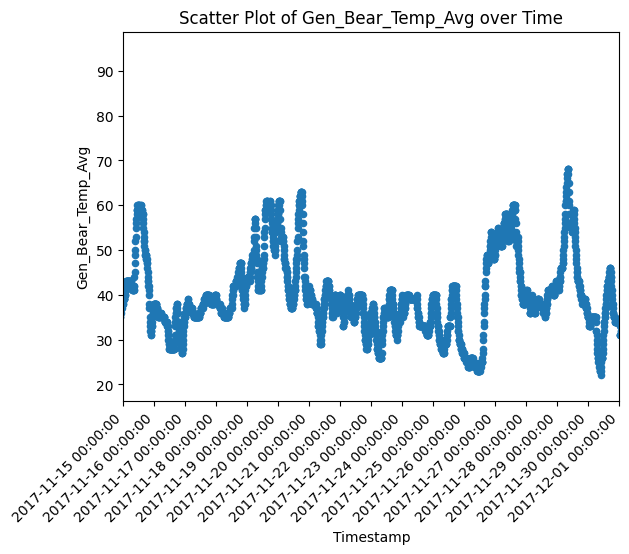

In [13]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2017-11-15'), pd.Timestamp('2017-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


<Axes: >

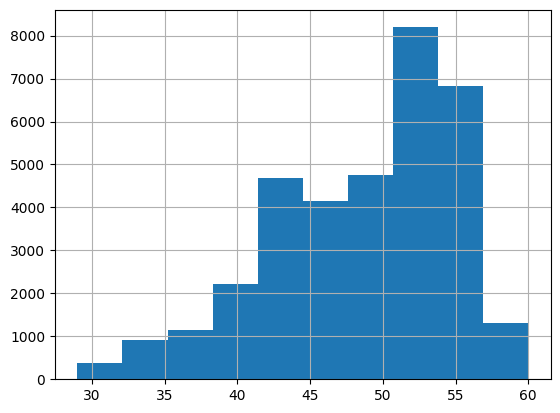

In [14]:
# check the "spread" of the data in a column
#this is interesting because often we do now want a long tail distribution of our data!
# for longtail distributions. make distribution logaritmic
merged_df["Gear_Oil_Temp_Avg"].hist()

### Creating the model:

In [15]:
from torch import tensor

In [16]:


#merged_df.isnull().sum().to_excel('na_summary.xlsx')
merged_df.shape

(34582, 123)

In [17]:
#import torch
#remove turbine id to have only numbers in dataframe
merged_df = merged_df.dropna()
merged_df = merged_df.drop("Turbine_ID", axis=1)

In [18]:
#dropping columns with NaN and Inf values showing up later

#merged_df = merged_df.drop(merged_df.columns[68:70], axis=1)



In [19]:
#These columns were observed to give NaN later in the process. We remove them here
merged_df = merged_df.drop(['Grd_Prod_PsbleInd_Avg','Grd_Prod_PsbleInd_Max','Grd_Prod_PsbleInd_Min'], axis=1)

In [20]:


#remove columns where all numbers are 0
cols_to_remove = merged_df.columns[(merged_df == 0).all()]

# Drop those columns from the DataFrame
merged_df_filtered = merged_df.drop(cols_to_remove, axis=1)

#create a list of independent variable names ["name1", "name2"] etc etc
indep_cols = merged_df_filtered.columns.to_list()
print(indep_cols)
indep_cols.remove("Gen_Bear_Temp_Avg")

['Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1', 'Prod_LatestAvg_TotReactPwr', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Spin_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std', 'Cont_VCP_ChokcoilTemp_Avg', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase

In [56]:
temp_cols = [col for col in merged_df_filtered.columns if "Temp" in col]
temp_cols

['Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Hyd_Oil_Temp_Avg',
 'Gear_Oil_Temp_Avg',
 'Gear_Bear_Temp_Avg',
 'Nac_Temp_Avg',
 'Amb_Temp_Avg',
 'HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg',
 'Grd_InverterPhase1_Temp_Avg',
 'Cont_Top_Temp_Avg',
 'Cont_Hub_Temp_Avg',
 'Cont_VCP_Temp_Avg',
 'Gen_SlipRing_Temp_Avg',
 'Spin_Temp_Avg',
 'Cont_VCP_ChokcoilTemp_Avg',
 'Grd_RtrInvPhase1_Temp_Avg',
 'Grd_RtrInvPhase2_Temp_Avg',
 'Grd_RtrInvPhase3_Temp_Avg',
 'Cont_VCP_WtrTemp_Avg',
 'Grd_Busbar_Temp_Avg',
 'Gen_Bear2_Temp_Avg',
 'Min_AmbientTemp',
 'Max_AmbientTemp',
 'Avg_AmbientTemp']

In [60]:
for col in temp_cols:
    print(col)
    print(merged_df_filtered[col].min())
    print()

Gen_Bear_Temp_Avg
20.0

Gen_Phase1_Temp_Avg
24

Gen_Phase2_Temp_Avg
24

Gen_Phase3_Temp_Avg
24

Hyd_Oil_Temp_Avg
24

Gear_Oil_Temp_Avg
29

Gear_Bear_Temp_Avg
27

Nac_Temp_Avg
17

Amb_Temp_Avg
7

HVTrafo_Phase1_Temp_Avg
44

HVTrafo_Phase2_Temp_Avg
45

HVTrafo_Phase3_Temp_Avg
45

Grd_InverterPhase1_Temp_Avg
29

Cont_Top_Temp_Avg
21

Cont_Hub_Temp_Avg
17

Cont_VCP_Temp_Avg
27

Gen_SlipRing_Temp_Avg
14

Spin_Temp_Avg
10

Cont_VCP_ChokcoilTemp_Avg
20

Grd_RtrInvPhase1_Temp_Avg
29

Grd_RtrInvPhase2_Temp_Avg
29

Grd_RtrInvPhase3_Temp_Avg
29

Cont_VCP_WtrTemp_Avg
23

Grd_Busbar_Temp_Avg
20

Gen_Bear2_Temp_Avg
21

Min_AmbientTemp
6.0

Max_AmbientTemp
7

Avg_AmbientTemp
6.0



In [77]:
#datetime needs to be a able to convert to a float. Making it just a month as a number between 1 and 12
if isinstance(merged_df_filtered["Timestamp"].iloc[2], pd.Timestamp):
    merged_df_filtered['Timestamp'] = merged_df_filtered['Timestamp'].dt.month.astype(float)

In [94]:
merged_df_filtered

,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Anemometer1_Freq,Anemometer1_Offset,Anemometer1_CorrGain,Anemometer2_Freq,Anemometer2_Offset,Anemometer2_CorrGain,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
0,12.0,1255.5,1239.3,1248.8,2.9,39.0,63,63,63,31,...,0.0499,0.24,1,0.0499,0.24,1,600,78,77,420
1,12.0,1253.6,211.8,819.4,499.1,38.0,57,58,57,31,...,0.0499,0.24,1,0.0499,0.24,1,600,75,74,420
2,12.0,1259.1,1233.3,1249.5,3.4,36.0,59,59,59,31,...,0.0499,0.24,1,0.0499,0.24,1,600,114,112,420
3,12.0,1269.0,1233.8,1250.0,5.4,37.0,61,61,61,31,...,0.0499,0.24,1,0.0499,0.24,1,600,114,111,420
4,12.0,1334.9,1218.3,1254.0,18.1,37.0,61,61,61,30,...,0.0499,0.24,1,0.0499,0.24,1,600,109,107,420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34577,5.0,1638.7,1274.4,1484.2,89.7,44.0,66,66,65,33,...,0.0499,0.24,1,0.0499,0.24,1,600,167,157,408
34578,5.0,87.3,0.0,38.1,25.0,27.0,30,30,29,33,...,0.0499,0.24,1,0.0499,0.24,1,600,23,22,408
34579,5.0,1771.8,1480.0,1640.1,49.1,62.0,102,101,99,41,...,0.0499,0.24,1,0.0499,0.24,1,600,163,195,408
34580,5.0,1690.7,1511.8,1652.4,28.8,68.0,113,112,109,47,...,0.0499,0.24,1,0.0499,0.24,1,600,152,181,408


In [95]:
rep_cols = ["Gen_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Phase1_Temp_Avg", "Nac_temp", "Humidity", "Wind_Speed"]

"Rep" indicates that the variable is a replication of the independent and dependent variables from the reseach paper "Fault detection of a wind turbine generator bearing using interpretable machine learning". We are going to try and repeat this project in a similar method before going for the deep model

In [96]:
t_indep_rep_tensor = tensor(merged_df_filtered[rep_cols].values, dtype=torch.float)

KeyError: "['Gen_RPM', 'Gen_Phase_Temp', 'Nac_temp', 'Humidity', 'Wind_Speed'] not in index"

In [22]:
#creates a tensor t_indep from merged_df.values for the independent variables and saves them as flaots in torch format
t_indep = tensor(merged_df_filtered[indep_cols].values, dtype=torch.float)

In [23]:
# dependent variable
# our dependent is going to be generator bearing average temperature "Gen_Bear_Temp_Avg"

t_dep = tensor(merged_df_filtered.Gen_Bear_Temp_Avg.values)


Have defined X and y. 

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

In [24]:
n_coeff = t_indep.shape[1] #number of coefficients in our model
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([ 0.3129, -0.2134, -0.4375,  0.2306, -0.3497, -0.1950,  0.4173, -0.3691,
         0.3730, -0.4326,  0.1698,  0.3791,  0.4077, -0.3230,  0.2591, -0.1040,
        -0.1824, -0.1817, -0.1047, -0.3136, -0.4108, -0.2609,  0.4469,  0.3861,
        -0.3264,  0.0863,  0.3504,  0.3544,  0.1548, -0.4111, -0.3540, -0.3779,
         0.0631,  0.4121, -0.0361, -0.0421, -0.0964, -0.1928,  0.1592, -0.1601,
        -0.0441, -0.1724, -0.4123,  0.1069,  0.2448, -0.0069,  0.1813, -0.1984,
        -0.3306,  0.3939,  0.0561, -0.1576,  0.0203, -0.2737, -0.2130,  0.4213,
        -0.1684, -0.4360,  0.2797, -0.3466, -0.3627,  0.4176, -0.1163,  0.0062,
         0.1389,  0.2711,  0.0698,  0.4274,  0.3364, -0.0068,  0.3965,  0.1762,
        -0.3670, -0.2925, -0.2598, -0.2108,  0.1930,  0.0470,  0.1434, -0.2353,
        -0.1245,  0.0623, -0.0300,  0.2908, -0.1630, -0.2209, -0.1588,  0.0508,
         0.4521, -0.2868, -0.0066,  0.2477, -0.2778, -0.0027, -0.0032,  0.3260,
        -0.1487, -0.3354,  0.2090,  0.12

In [25]:
#checking if compatible with lesson. Jeremy explains broadcasting. 
#t_indep*coeffs

In [26]:
#To improve our model we do the element wise division of the maximum of each column.
# This is to improve the properties of the model when multiplications are being performed by numbers less than 1
# we want all values in the dataset to be "simular size" and is called normalizing


vals, indices = t_indep.max(dim=0)


In [27]:
#normalizing the data by division by the max of the column. (making the values more similar)
t_indep = t_indep / vals

In [28]:
#making a prediction with our random coefficients:
preds = (t_indep*coeffs).sum(axis=1)


In [29]:
#Printing predictions
"""
t_np = preds.numpy() #convert to Numpy array
preds_print = pd.DataFrame(t_np) #convert to a dataframe
preds_print.to_csv("predictions",index=False) #save to file
"""

'\nt_np = preds.numpy() #convert to Numpy array\npreds_print = pd.DataFrame(t_np) #convert to a dataframe\npreds_print.to_csv("predictions",index=False) #save to file\n'

In [30]:
preds[1:]

tensor([-3.2958, -2.6750, -2.4805,  ..., -2.2974, -2.3036, -2.0006])

In [31]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(48.3865, dtype=torch.float64)

In [32]:
def calc_preds(coeffs, indeps):
    return (indeps*coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs,indeps)-deps).mean()

# Gradient Descent steps


In [33]:
coeffs.requires_grad_()

tensor([ 0.3129, -0.2134, -0.4375,  0.2306, -0.3497, -0.1950,  0.4173, -0.3691,
         0.3730, -0.4326,  0.1698,  0.3791,  0.4077, -0.3230,  0.2591, -0.1040,
        -0.1824, -0.1817, -0.1047, -0.3136, -0.4108, -0.2609,  0.4469,  0.3861,
        -0.3264,  0.0863,  0.3504,  0.3544,  0.1548, -0.4111, -0.3540, -0.3779,
         0.0631,  0.4121, -0.0361, -0.0421, -0.0964, -0.1928,  0.1592, -0.1601,
        -0.0441, -0.1724, -0.4123,  0.1069,  0.2448, -0.0069,  0.1813, -0.1984,
        -0.3306,  0.3939,  0.0561, -0.1576,  0.0203, -0.2737, -0.2130,  0.4213,
        -0.1684, -0.4360,  0.2797, -0.3466, -0.3627,  0.4176, -0.1163,  0.0062,
         0.1389,  0.2711,  0.0698,  0.4274,  0.3364, -0.0068,  0.3965,  0.1762,
        -0.3670, -0.2925, -0.2598, -0.2108,  0.1930,  0.0470,  0.1434, -0.2353,
        -0.1245,  0.0623, -0.0300,  0.2908, -0.1630, -0.2209, -0.1588,  0.0508,
         0.4521, -0.2868, -0.0066,  0.2477, -0.2778, -0.0027, -0.0032,  0.3260,
        -0.1487, -0.3354,  0.2090,  0.12

In [34]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(48.3865, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [35]:
loss.backward()

In [36]:
coeffs.grad

tensor([-7.0916e-01, -6.1747e-01, -5.6158e-01, -6.3400e-01, -8.4063e-02,
        -4.7124e-01, -4.7565e-01, -4.8169e-01, -7.6813e-01, -8.0786e-01,
        -7.5949e-01, -6.3334e-01, -6.1921e-01, -5.5683e-01, -6.3035e-01,
        -1.9170e-01, -1.5207e-01, -2.8985e-01, -1.7024e-02, -1.1271e-03,
        -4.4682e-01, -5.6752e-01,  8.6016e-01, -2.6953e-01, -2.6826e-01,
         1.8372e-01,  1.1553e-01,  1.1884e-01, -7.0212e-01, -6.6472e-01,
        -6.3447e-01, -7.2822e-01, -6.7740e-01, -6.1919e-01, -6.8813e-01,
        -5.4165e-01, -5.5166e-01, -8.2884e-02, -1.6358e-01, -1.1183e-01,
        -3.8217e-02, -6.0952e-01, -7.0845e-01, -7.0619e-01, -7.2384e-01,
        -7.3849e-01, -2.6900e-01, -8.4926e-01, -9.9799e-01, -9.6106e-01,
        -9.6205e-01, -9.5863e-01, -2.7559e-01, -2.8157e-01, -2.7686e-01,
        -3.5195e-01, -1.6532e-01, -6.1323e-01, -8.4602e-02, -2.9444e-01,
        -8.6917e-02,  1.1889e-01,  1.8981e-02,  3.6164e-01, -4.0752e-02,
        -2.8844e-01, -3.9784e-01, -1.7300e-01, -1.1

In [37]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad*0.1)            #0.1 is our learning rate here
    print(calc_loss(coeffs,t_indep,t_dep))

tensor(44.9018, dtype=torch.float64)


# Training the model

In [38]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split = RandomSplitter(seed=42)(merged_df_filtered)


In [39]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

len(trn_indep), len(val_indep)



(27660, 6915)

In [40]:
def update_coeffs(coeffs,lr): coeffs.sub_(coeffs.grad * lr)


In [41]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [42]:
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [43]:
def train_model(epochs = 30, lr= 0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [44]:
coeffs = train_model(18, lr=0.02)

46.372; 45.676; 44.283; 42.193; 39.407; 35.925; 31.746; 26.870; 21.299; 15.124; 9.755; 8.132; 10.461; 14.825; 19.968; 25.443; 30.477; 34.832; 

In [45]:
def show_coeffs(): 
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Timestamp': tensor(1.2201),
 'Gen_RPM_Max': tensor(1.7001),
 'Gen_RPM_Min': tensor(1.6846),
 'Gen_RPM_Avg': tensor(1.3900),
 'Gen_RPM_Std': tensor(-0.0680),
 'Gen_Phase1_Temp_Avg': tensor(0.8861),
 'Gen_Phase2_Temp_Avg': tensor(1.6991),
 'Gen_Phase3_Temp_Avg': tensor(1.5390),
 'Hyd_Oil_Temp_Avg': tensor(2.1503),
 'Gear_Oil_Temp_Avg': tensor(1.5305),
 'Gear_Bear_Temp_Avg': tensor(2.0754),
 'Nac_Temp_Avg': tensor(1.9145),
 'Rtr_RPM_Max': tensor(1.7397),
 'Rtr_RPM_Min': tensor(1.6668),
 'Rtr_RPM_Avg': tensor(1.2514),
 'Amb_WindSpeed_Max': tensor(0.4874),
 'Amb_WindSpeed_Min': tensor(0.2020),
 'Amb_WindSpeed_Avg': tensor(0.5013),
 'Amb_WindSpeed_Std': tensor(0.0923),
 'Amb_WindDir_Relative_Avg': tensor(0.0882),
 'Amb_WindDir_Abs_Avg': tensor(0.9943),
 'Amb_Temp_Avg': tensor(1.6973),
 'Prod_LatestAvg_ActPwrGen0': tensor(-2.0172),
 'Prod_LatestAvg_ActPwrGen1': tensor(0.4868),
 'Prod_LatestAvg_TotActPwr': tensor(1.0720),
 'Prod_LatestAvg_ReactPwrGen0': tensor(-0.2744),
 'Prod_LatestAvg_Reac

# Measuring accuracy 

In [46]:
preds = calc_preds(coeffs, val_indep)


`val_dep` are the values of the average temp of the bearing. That is, this is the target for prediction.

In [61]:
val_dep

tensor([55., 51., 36.,  ..., 26., 29., 34.], dtype=torch.float64)

In [62]:
preds

tensor([89.8420, 93.2572, 82.5447,  ..., 71.5687, 72.3768, 72.8175])

In [67]:
preds.mean()

tensor(84.3921)

In [69]:
val_dep.mean()

tensor(45.9863, dtype=torch.float64)

In [74]:
from sklearn.metrics import mean_squared_error

In [75]:
mean_squared_error(preds, val_dep)

1523.4929346807521

Text(0, 0.5, 'Predicted temperature')

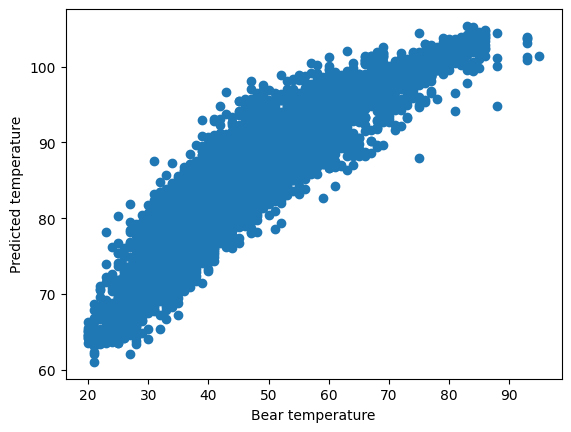

In [71]:
plt.scatter(val_dep, preds)
plt.xlabel('Bearing temperature')
plt.ylabel('Predicted temperature')
#plt.xlim(10,60)
#plt.ylim(10,120)

In [73]:
val_dep.bool()

tensor([True, True, True,  ..., True, True, True])

In [51]:
# TMP from fastai
results = val_dep.bool()==(preds>0.02)
results[:150]


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [48]:
results.float().mean() #if we get 1.0 its sus???

tensor(1.)

In [49]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(1.)

# Using Sigmoid

In [50]:
preds[:28]

tensor([ 89.8420,  93.2572,  82.5447, 100.2433,  91.1214,  87.3694,  68.0837,
         74.4073,  77.8735,  64.5406,  72.0238,  75.1462,  75.2432,  85.0805,
         81.6532,  99.4124,  71.6825,  89.9575,  64.7446,  83.6615,  90.6541,
         93.7175,  89.7016,  79.4298,  66.3505,  73.7166, 100.6880,  77.3151])